In [1]:
# If running locally and not all packages are installed, uncomment and run:
!pip install torch torch-geometric matplotlib scikit-learn


  Using cached torch-2.7.0-cp313-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached scikit_learn-1.6.1-cp313-cp313-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached aiohttp-3.11.18-cp313-cp313-macosx_11_0_arm64.whl.metadata (7.7 kB)
  Using cached numpy-2.2.5-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.m

In [2]:
import torch
from torch_geometric.datasets import WikiCS
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report


In [3]:
# Load the Wiki-CS dataset (automatically downloads if not present)
dataset = WikiCS(root='wikics')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Feature dimension: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


/Users/kushagrasrivastva/Desktop/gnn-project/.venv/lib/python3.13/site-packages/torch_geometric/datasets/wikics.py:45: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(
Processing...


Number of nodes: 11701
Number of edges: 431726
Feature dimension: 300
Number of classes: 10


Done!


In [4]:
# Wiki-CS provides 20 train/val splits; we'll use the first split (index 0)
train_mask = data.train_mask[:, 0]
val_mask = data.val_mask[:, 0]
test_mask = data.test_mask

print(f"Train nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}")


Train nodes: 580
Validation nodes: 1769
Test nodes: 5847


In [5]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(
    in_channels=dataset.num_node_features,
    hidden_channels=128,
    out_channels=dataset.num_classes,
    num_layers=2,
    dropout=0.5
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [7]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[mask].argmax(dim=1)
    acc = (pred == data.y[mask]).float().mean().item()
    return acc, pred.cpu().numpy(), data.y[mask].cpu().numpy()


In [8]:
best_val_acc = 0
patience = 20
patience_counter = 0
train_losses = []
val_accuracies = []

for epoch in range(1, 201):
    loss = train()
    train_losses.append(loss)
    val_acc, _, _ = evaluate(val_mask)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 010, Loss: 0.9336, Val Acc: 0.7383
Epoch 020, Loss: 0.5956, Val Acc: 0.8044
Epoch 030, Loss: 0.4444, Val Acc: 0.8197
Epoch 040, Loss: 0.3275, Val Acc: 0.8202
Epoch 050, Loss: 0.2757, Val Acc: 0.8168
Epoch 060, Loss: 0.2316, Val Acc: 0.8140
Epoch 070, Loss: 0.1862, Val Acc: 0.8146
Early stopping at epoch 71


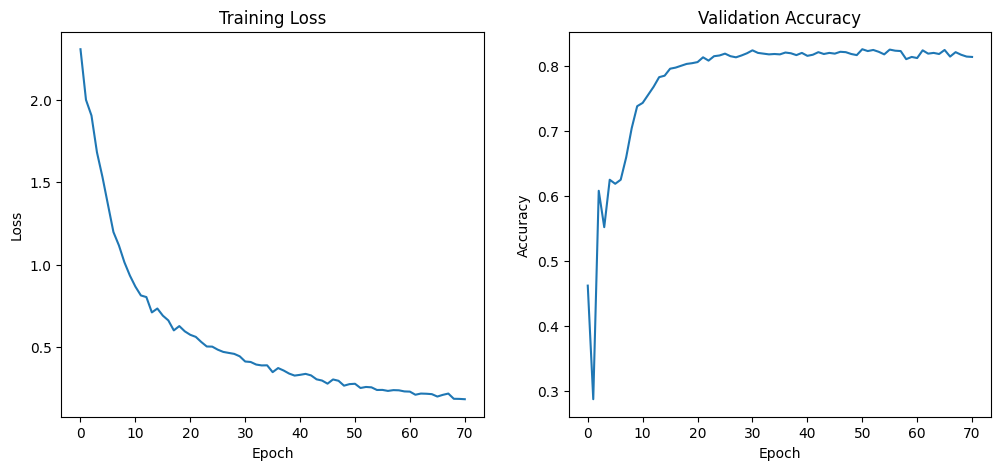

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [10]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))
test_acc, y_pred, y_true = evaluate(test_mask)
print(f'Test Accuracy: {test_acc:.4f}')
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy: 0.7972
              precision    recall  f1-score   support

           0     0.9244    0.7483    0.8271       147
           1     0.7930    0.7477    0.7697       333
           2     0.7387    0.8067    0.7712      1076
           3     0.8641    0.8095    0.8359       966
           4     0.8630    0.8753    0.8691      1339
           5     0.7729    0.7154    0.7430       390
           6     0.8598    0.6845    0.7622       206
           7     0.6842    0.6019    0.6404       432
           8     0.6944    0.6098    0.6494       246
           9     0.7602    0.9129    0.8296       712

    accuracy                         0.7972      5847
   macro avg     0.7955    0.7512    0.7698      5847
weighted avg     0.7989    0.7972    0.7958      5847



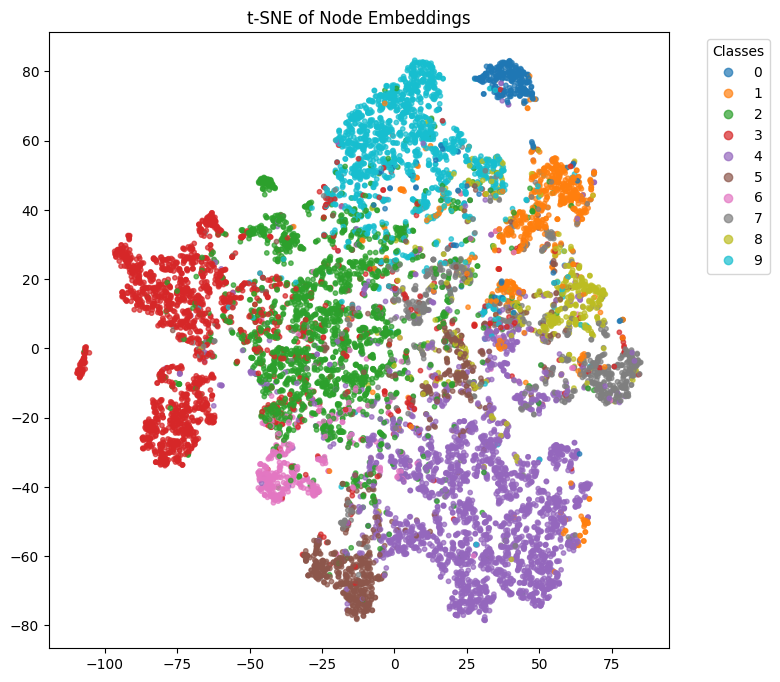

In [11]:
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=data.y.cpu().numpy(), cmap='tab10', alpha=0.7, s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE of Node Embeddings')
plt.show()
